## Saliency maps and GradCAM

In [ ]:
# importing the required libraries
!pip -qq install tf_keras_vis 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import cv2 
import glob
import os
import pickle
import zipfile
import tensorflow as tf
from tensorflow import keras
from __future__ import print_function
from keras.preprocessing import image
from keras.applications import imagenet_utils
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from PIL import Image

In [ ]:
covid=cv2.imread('covid.jpeg')
normal=cv2.imread('normal.jpeg')
pneumonia=cv2.imread('pneumonia.jpeg')

In [ ]:
r_covid=cv2.resize(covid,(224,224),cv2.INTER_AREA)
r_normal=cv2.resize(normal,(224,224),cv2.INTER_AREA)
r_pneumonia=cv2.resize(pneumonia,(224,224),cv2.INTER_AREA)

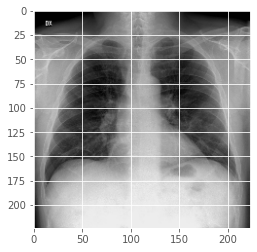

In [ ]:
plt.imshow(r_covid)

### Preprocessing the images

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
covid=preprocess_input(r_covid)
normal=preprocess_input(r_normal)
pneumonia=preprocess_input(r_pneumonia)

In [ ]:
covid=np.expand_dims(covid,axis=0)
normal=np.expand_dims(normal,axis=0)
pneumonia=np.expand_dims(pneumonia,axis=0)

### Import pretrained model

In [ ]:
from tensorflow.keras.applications import DenseNet201
base_model=DenseNet201(input_shape=[224,224,3],weights='imagenet',include_top=False) 

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
x=base_model.output
base_model.trainable=False
x1=keras.layers.GlobalAveragePooling2D()(x)
x2=keras.layers.Dense(512,activation='relu')(x1)
preds=keras.layers.Dense(3,activation='softmax')(x2) 
DenseNet=keras.models.Model(inputs=[base_model.input],outputs=[preds]) #specify the inputs and outputs

### Loading of weights

In [ ]:
with open("x2.txt", "rb") as fp:
  weightsAndBiases_2=pickle.load(fp)
with open("pred.txt", "rb") as fp:
  weightsAndBiases_1=pickle.load(fp)

In [ ]:
DenseNet.layers[-1].set_weights(weightsAndBiases_1)
DenseNet.layers[-2].set_weights(weightsAndBiases_2)

In [ ]:
DenseNet.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])

In [ ]:
keys={0:'covid',1:'normal',2:'pneumonia'}

### Helper function to create saliency maps

In [ ]:

# Define a function here to replace "Softmax activation" of the final dense layer with "linear" as we want the class scores, not the class
def model_modifier(m):
  m.layers[-1].activation=tf.keras.activations.linear
  return m
  
# Defining a function to generate saliency graphs for the top 3 predicted classes
def saliency_graphs(model, img):

  # Create Saliency object
  saliency = Saliency(model, model_modifier)

  # input image that is pre-processed
  input_image = img

  # predict on the input image
  y_pred = model.predict(input_image)

  # return the indices in decreasing order of predicted probability
  class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

  for i, class_idx in enumerate(class_idxs_sorted[:3]):

    # Define loss function for the class label.
    # The 'output' variable refer to the output of the model
    loss = lambda output: tf.keras.backend.mean(output[:, class_idx])   

    # Generate saliency map with smoothing. Smoothing reduces noise in the Saliency map
    # smooth_samples is the number of calculating gradients iterations
    saliency_map = saliency(loss, input_image[0,...], smooth_samples=20,smooth_noise=0.20)    
    saliency_map = normalize(saliency_map)
    plot_saliency_map(saliency_map,img,y_pred,i,class_idx)


# Defining a function to plot saliency map
def plot_saliency_map(sal_map, img, y_pred, i, class_idx):

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  ax[0].imshow(r_covid)
  j = ax[1].imshow(sal_map[0],cmap="jet",alpha=0.8)
  fig.colorbar(j)
  for axe in ax:
    axe.grid(False)
    axe.axis('off')
  plt.suptitle("Predicted(class={}) = {:5.2f}".format(keys[class_idx],y_pred[0,class_idx]))


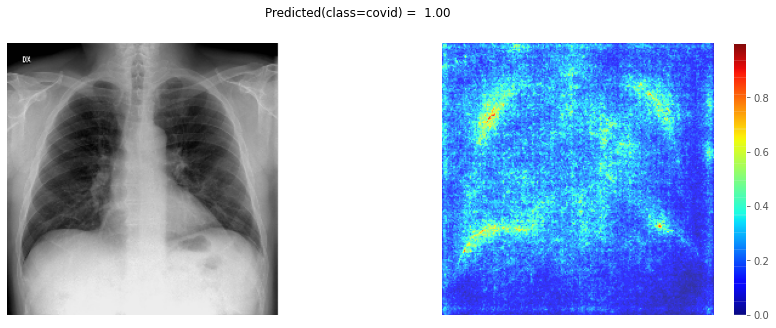

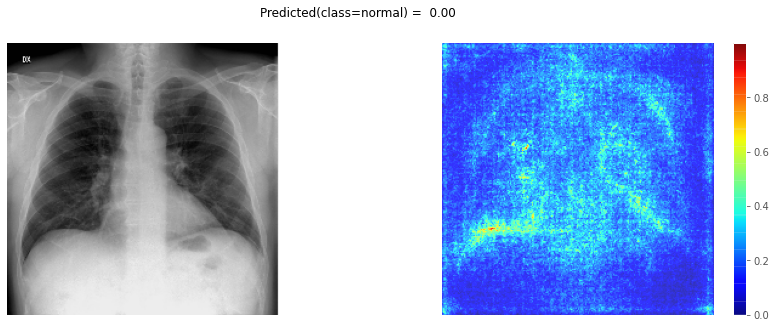

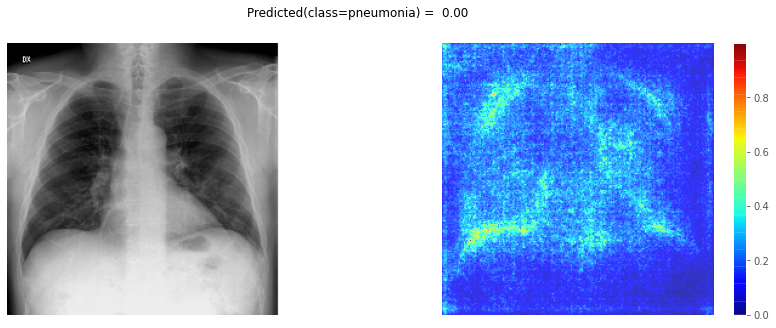

In [ ]:
# Generate saliency graphs by calling the helper functions for 'covid' for DenseNet model
saliency_graphs(DenseNet,covid)

### Helper function to create GradCAM

In [ ]:

# Define a function here to replace "Softmax activation" of the final dense layer with "linear" as we want the class scores, not the class
def model_modifier(m):
  m.layers[-1].activation=tf.keras.activations.linear
  return m
  
# Defining a function to generate saliency graphs for the top 3 predicted classes
def GradCAM(model, img):

  # Grad cam
  gradcam = Gradcam(model, model_modifier=model_modifier, clone=False)

  # input image that is pre-processed
  input_image = img

  # predict on the input image
  y_pred = model.predict(input_image)

  # return the indices in decreasing order of predicted probability
  class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

  for i, class_idx in enumerate(class_idxs_sorted[:3]):

    # Define loss function for the class label.
    # The 'output' variable refer to the output of the model
    loss = lambda output: tf.keras.backend.mean(output[:, class_idx])   

    # Generate GradCAM with smoothing. Smoothing reduces noise in the GradCAM
    # smooth_samples is the number of calculating gradients iterations
    cam = gradcam(loss, img, penultimate_layer=-1) # model.layers number
    cam = normalize(cam)
    plot_GradCAM(cam,img,y_pred,i,class_idx)


# Defining a function to GradCAM
def plot_GradCAM(cam, img, y_pred, i, class_idx):

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
  ax[0].imshow(r_covid)
  ax[1].imshow(r_covid)
  heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
  #superimposed_img = (heatmap[0] * 0.4) + img[0]
  j = ax[1].imshow(heatmap, cmap="jet",alpha=0.5)
  fig.colorbar(j)
  for axe in ax:
    axe.grid(False)
    axe.axis('off')
  plt.suptitle("Predicted(class={}) = {:5.2f}".format(keys[class_idx],y_pred[0,class_idx]))


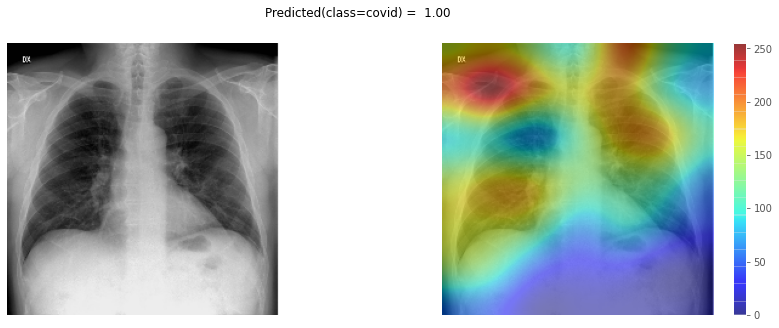

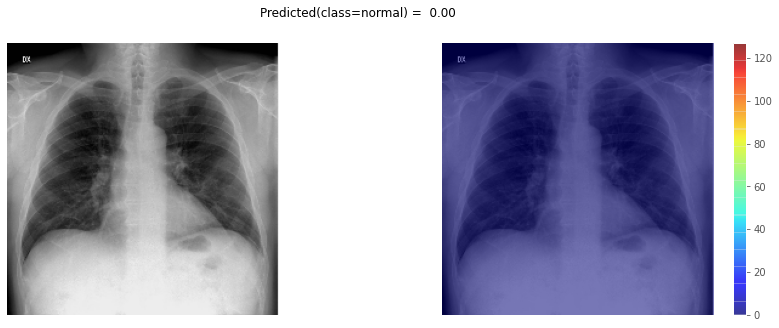

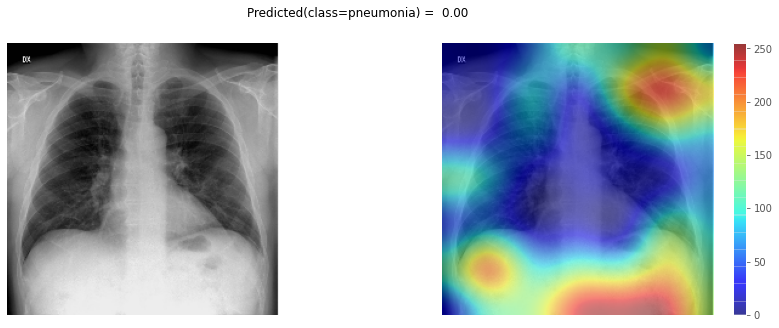

In [ ]:
# Generate GradCAM by calling the helper functions for 'covid' for DenseNet model
GradCAM(DenseNet, covid)

#### From saliency maps and gradCAM's, we can get to know the regions in the image where the neural network focuses more. These regions have a much higher influence on the output than other regions. They can be termed 'Vulnerable areas', on which radiologists can focus more!